在深度学习中，我们常用小批量随机梯度下降的方法来进行参数训练（因为用全体的数据太大了）

想要实现这个，我们需要在python中实现一些向量化操作，而不是使用计算开销巨大的for循环

In [90]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l # 这里的torch不是说那个torch，而是李沐老师写的torch教学代码

In [91]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

下面这个#@save就是李沐老师自定义的一个注释，意思是这个函数已经被封装到了d2l包里面，后面也可以调用的，而不是说为了这一部分课程而临时一次性定义的

In [92]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

接下来看一下for和向量化操作的时间差距（所以说for循环害人～

In [93]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.24919 sec'

In [94]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00080 sec'

虽然深度学习框架已经造好了很多轮子，但是有时候为了具体的研究也需要自己造一点轮子，接下来手动实现一个最简单的线性回归模型

In [95]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [96]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    """这里就是加上了噪声"""
    return X, y.reshape((-1, 1)) # 这个reshape用法中的-1其实就是，这个我不指定，让numpy自己算，我只确定我的列只要1列

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

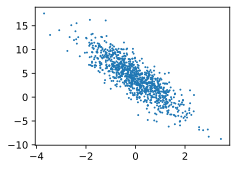

In [97]:
"""这个地方把第二个feature调出来
其实可以发现确实是存在线性关系"""
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [98]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

上面我们定义了一个生成器函数，通过yeild这个关键字，这样函数返回就不是直接返回一个值，而是返回一个生成器

其实这里就是把数据的标签打乱，这样每次按照batch取数据，取出来的就是打乱之后的数据了

GPU为啥适合用来训练深度学习模型呢？李沐老师是这样解释的：
通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

In [99]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.2395,  0.5520],
        [ 0.6966, -0.2455],
        [ 0.5305, -1.1836],
        [ 1.9003, -1.3497],
        [-0.2459, -0.1694],
        [ 0.1229, -1.1878],
        [ 1.4266,  0.8994],
        [-0.9257,  0.2505],
        [-1.9068, -0.0286],
        [-0.5358, -0.4048]]) 
 tensor([[ 4.7980],
        [ 6.4492],
        [ 9.2961],
        [12.5863],
        [ 4.2751],
        [ 8.4905],
        [ 3.9897],
        [ 1.5163],
        [ 0.4637],
        [ 4.4805]])


上面这个batch生成器例子看起来挺好的，但是对于实际工业界的大数据集应用来说还是不够的，太慢了，而且内存开销十分巨大

接下来，我们就可以设置一个参数的初始值，然后我们可以开始不断的优化来得到最终的参数值

In [100]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
"""注意这里都要用上requires_grad=True"""

'注意这里都要用上requires_grad=True'

In [101]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b # 这里用mm那个函数也可以的，实际上加上b这个标量，也用了广播机制

In [102]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [103]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad(): # 这里这个with条件语句，其实就是为了确保，每次我们把梯度重置了，不然梯度一直累加肯定是错的
        for param in params:
            param -= lr * param.grad / batch_size # 这里从公式来看，其实不用加上batch，但是其实是需要的。因为我们模型构造的方法，其实是计算了一个batch所有样本的loss的合，我们需要加上一个batch来得到均值
            param.grad.zero_()

In [104]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 这也就是为啥，我们上面做sgd的时候需要加一个batch size了
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045706
epoch 2, loss 0.000175
epoch 3, loss 0.000052
epoch 4, loss 0.000051
epoch 5, loss 0.000051
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051


In [105]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-1.1945e-04,  2.8849e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


其实可以发现，在一整个训练任务中，总的参数更新次数是epoch*batch_number，下面是对batch和epoch的一些理解：
1. 为啥要用batch，其实就是因为如果用整个数据集一次性训练，太大了，没办法发挥GPU的并行计算优势
2. 而用了batch之后，如果说我们batch选的比较恰当，其实训练一个batch可能几百个样本对GPU来说和训练一个样本来说是同样的时间，这样大大加快了训练速度
3. 用batch之后，其实我们还是用了整体的数据集去训练，但是我们的整体用时理论上会大大降低
4. 这样其实感觉还有个好处，增加了参数更新次数，感觉可能可以用一个比较小的learning rate多训练几次？？这个我猜的

接下来，我们用torch框架来简洁的实现一下线性回归模型

In [106]:
# 首先是和之前一样的，用我们定义好的函数来生成一个数据集
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [107]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

上面这段代码写的比较绕，第一次接触torch可能会看不懂，下面进行一些说明：
1. 首先上面这个load_array函数，接收的data_arrays参数，就是我们生成的最简单的data，也就是我们的最原始的X和y，torch里面的tensor形式，其实本质上就是传入了两个数组，通过data.TensorDataset这个函数转化为方便torch框架方便处理的形式储存起来
2. 返回的data.DataLoader这个函数，首先我们通过上面构造好的torch数据形式dataset把数据传进去，然后指定batch_size、shuffle，这个函数啥意思呢，其实就是为了SGD优化做准备的。我们上面得到的dataset，只是一个数据的集合，包括了所有的数据，但是前面我们知道，我们需要进行SGD优化，要取batch。所以，data.DataLoader这个函数其实就人如其名，起到了一个“数据读取”的作用，从原始的torch数据格式中，按照我们要求的batch_size，把需要的小批量数据给我们拿出来，并且shuffle参数保证了随机性。
3. 我们上面手动实现线性回归的时候，我们使用了yield函数来构造一个迭代器。那这里我们返回的是data.DataLoader这么一个对象，所以下面的代码我们就用iter函数来构造这个迭代器了。效果是完全一样的，只不过这里用了别人造好的轮子。

In [108]:
next(iter(data_iter))

[tensor([[-0.7814,  0.3655],
         [ 1.3738, -0.2467],
         [ 0.7514, -1.0382],
         [ 0.8121,  0.3897],
         [-0.5106, -0.7249],
         [-0.1958,  0.5337],
         [-0.1255,  0.8905],
         [ 0.0994, -3.2201],
         [-1.4577, -0.9154],
         [-1.2752, -3.7102]]),
 tensor([[ 1.4056],
         [ 7.7854],
         [ 9.2359],
         [ 4.4886],
         [ 5.6561],
         [ 2.0023],
         [ 0.9075],
         [15.3410],
         [ 4.4214],
         [14.2617]])]

In [109]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

torch里面，全连接层是通过Linear来定义的，两个参数分别是输入和输出的维度

nn里面最基础的一个类，就是Sequential类，这里我们就使用了一个Sequential类的实例

Sequential类人如其名，第一个层的输出就是第二个层的输入，是按照顺序进行的，当然这里就一层，直接用一个dense layer也是可以的

In [110]:
"""这里我们就可以开始访问网络中的元素了
这里的意思是 第一层网络的w和b两个参数 参数的啥呢 参数的具体值是啥 也就是data
接下来就用和前面相似的 带有后下划线的函数进行参数初始化"""
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.])

In [111]:
loss = nn.MSELoss(reduction='mean')
# 这里定义了损失函数
# 要注意，这里的reduction默认是mean，也就是求了平均损失
# 如果要像我们在上面手动实现那样，计算损失的和，那reduction就要改成sum，不过这样后面就要记得除batch size

In [112]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# 这里就是构造一个优化器，需要传入两类变量，一个是要优化的参数，一个是我们设定的超参数

In [113]:
# 最后，就是实现训练过程了
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter: # data_iter本身也就是一个迭代器
        l = loss(net(X) ,y)
        trainer.zero_grad() # 每次得把参数的梯度清除，我们手动实现的时候是写到sgd函数里面了，torch是封装在SGD类里面，干的事情是一样的
        l.backward() # 反向传播
        trainer.step() # 按照步长进行更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000254
epoch 2, loss 0.000097
epoch 3, loss 0.000098


In [114]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0001, -0.0006])
b的估计误差： tensor([0.0007])


## 小结

* 我们可以使用PyTorch的高级API更简洁地实现模型。
* 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数。
* 我们可以通过_结尾的方法将参数替换，从而初始化参数。
* 其实手动实现和用API是完全一样的思路，主要是搞清楚，深度学习的训练思路是啥：
    1. 初始化参数
    2. 定义损失函数，并且根据样本算损失是多少
    3. 损失函数对参数求导
    4. 用求出来的导数、梯度在一定的步长下，更新参数，从而让损失越来越小
    5. 炼丹成功
